In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import itertools
import numpy as np
import torch as tr
import pandas as pd
from matplotlib import pyplot as plt
from CSWSEM import *

In [3]:
def run_batch_exp(num_seeds,sem_kwargs,exp_kwargs):
  """ wrap wround seeds for single paramconfig
  """
  batch_dataL = []
  for seed in range(num_seeds):
    print('seed',seed)
    sem_kwargs['seed'] = seed
    # run
    sem = SEM(**sem_kwargs)
    task = CSWTask()
    exp,curr = task.generate_experiment(**exp_kwargs)
    sem_data = sem.forward_exp(exp,curr)
    # record
    sem.data.record_exp('condition',exp_kwargs['condition'])
    # collect
    sem_data_df = pd.DataFrame(sem_data,dtype='float64')
    batch_dataL.append(sem_data_df)
  return pd.concat(batch_dataL)

def run_BIexp(num_seeds,sem_kwargs,ntrain,ntest,condL):
  """ wrap around task conditions
  """
  exp_dataL = []
  exp_kwargs = {'n_train':ntrain,'n_test':ntest}
  for cond in condL:
    print(cond)
    exp_kwargs['condition'] = cond
    batch_data = run_batch_exp(num_seeds,sem_kwargs,exp_kwargs)
    exp_dataL.append(batch_data)
  return pd.concat(exp_dataL)

In [4]:
sem_kwargs={
  'nosplit':0,
  'alfa':10000000,
  'lmda':0.1,
  'seed':np.random.randint(99),
  'stsize':15,
  'learn_rate':0.05,
  'mode':5,
  'PE_thresh':None
}

In [5]:
DEBUG=0
if DEBUG:
  ntrain=40
  ntest=2
  condL=['single','interleaved']
else:
  ntrain=160
  ntest=40
  condL=['blocked','interleaved']

In [8]:
## GRIDSEARCH

n1 = 'mode'
L1 = ['PEdiff','PEargmin']
n2 = 'PE_thresh'
L2 = np.arange(0.054,0.071,0.008)
# L2 = [0.05]
print(L2)
num_seeds = 15

gsdataL = []
for idx,(v1,v2) in enumerate(itertools.product(L1,L2)):
  print(v1,v2)
  sem_kwargs[n1] = v1
  sem_kwargs[n2] = v2
  exp_data = run_BIexp(num_seeds,sem_kwargs,ntrain,ntest,condL)
  gsdataL.append(exp_data)
    
gsdata = pd.concat(gsdataL)
gsdata = gsdata.groupby(['condition','trial',n1,n2]).mean().reset_index()

[0.054 0.062 0.07 ]
PEdiff 0.054
blocked
seed 0
189
seed 1
175
seed 2
137
seed 3
111
seed 4
105
seed 5
129
seed 6
149
seed 7
149
seed 8
123
seed 9
81
seed 10
115
seed 11
157
seed 12
127
seed 13
177
seed 14
115
interleaved
seed 0
199
seed 1
181
seed 2
133
seed 3
127
seed 4
119
seed 5
129
seed 6
141
seed 7
137
seed 8
135
seed 9
109
seed 10
135
seed 11
127
seed 12
179
seed 13
199
seed 14
129
PEdiff 0.062
blocked
seed 0
189
seed 1
173
seed 2
105
seed 3
119
seed 4
143
seed 5
129
seed 6
171
seed 7
165
seed 8
143
seed 9
91
seed 10
129
seed 11
167
seed 12
165
seed 13
183
seed 14
135
interleaved
seed 0
199
seed 1
193
seed 2
157
seed 3
151
seed 4
177
seed 5
165
seed 6
165
seed 7
161
seed 8
153
seed 9
141
seed 10
153
seed 11
157
seed 12
183
seed 13
199
seed 14
149
PEdiff 0.07
blocked
seed 0
195
seed 1
177
seed 2
157
seed 3
157
seed 4
139
seed 5
143
seed 6
177
seed 7
175
seed 8
143
seed 9
129
seed 10
141
seed 11
165
seed 12
183
seed 13
187
seed 14
131
interleaved
seed 0
199
seed 1
195
seed 2
183
s

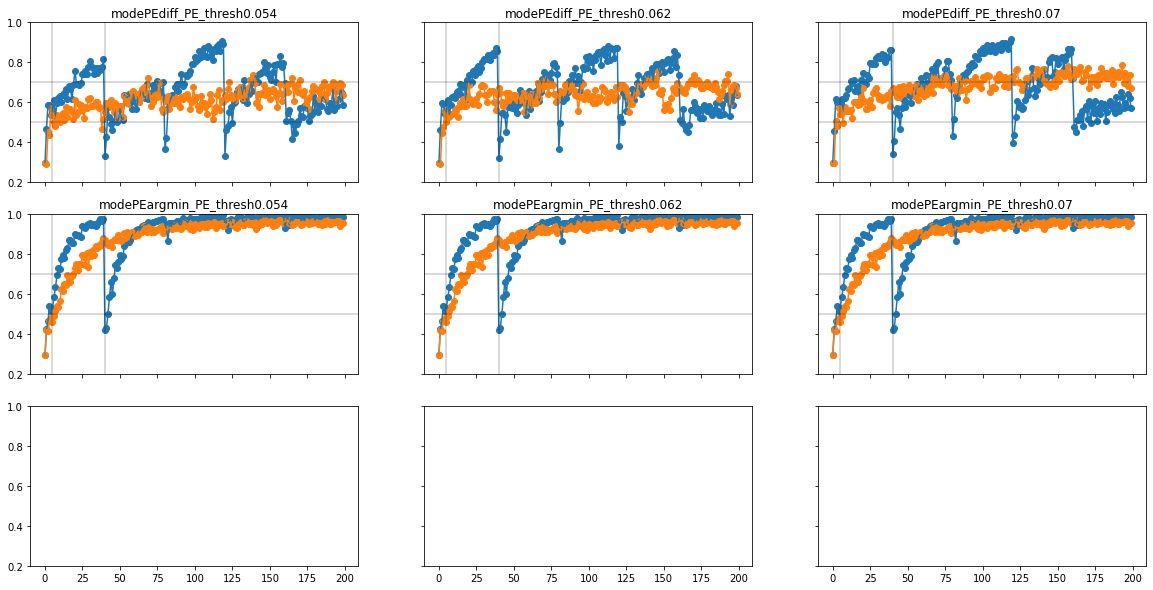

In [9]:
## PLT GRIDSEARCH
f,axar = plt.subplots(3,3,figsize=(20,10),sharey=True,sharex=True);axar=axar.reshape(-1)

for idx,(v1_,v2_) in enumerate(itertools.product(L1,L2)):
  ax = axar[idx]
  for c in condL:
    cdata = gsdata[(
      gsdata.condition==c)&(
      gsdata.loc[:,n1]==v1_)&(
      gsdata.loc[:,n2]==v2_)
    ]
    acc = 1-cdata.loss
    ax.plot(np.arange(len(acc)),acc)
    ax.scatter(np.arange(len(acc)),acc)
  ax.set_title('%s%s_%s%s'%(n1,v1_,n2,v2_))
  ax.set_ylim(0.2,1)
#   ax.set_xlim(0,20)
  ax.axhline(0.5,c='k',lw=.3)
  ax.axhline(0.7,c='k',lw=.3)
  ax.axvline(5,c='k',lw=.3)
  ax.axvline(40,c='k',lw=.3)
  
plt.savefig('figures/gs-%s&%s'%(n1,n2))